In [3]:
%pip install pandas
%pip install scipy
import matplotlib.pyplot as plt
import numpy as np
import yt
import matplotlib.cm as cm
from plot_variables import *
from yt.utilities.math_utils import ortho_find


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
from helper_functions import *

In [5]:
ds = yt.load("/disk14/sgordon/pleiades-11-12-23/seed1-bh-only/270msun/thermal-fb/1B.th.bf128/DD0600/DD0600")

yt : [INFO     ] 2024-03-28 13:32:56,038 Parameters: current_time              = 13.984875219842
yt : [INFO     ] 2024-03-28 13:32:56,039 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-03-28 13:32:56,040 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-03-28 13:32:56,058 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-03-28 13:32:56,059 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-03-28 13:32:56,060 Parameters: current_redshift          = 26.240077770767
yt : [INFO     ] 2024-03-28 13:32:56,061 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-03-28 13:32:56,062 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-03-28 13:32:56,063 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-03-28 13:32:56,063 Parameters: hubble_constant           = 0.71


In [22]:
data_files = ['data_files/data-1B.RSb01-2.csv', 
              #'data_files/data-2B.RSb01.csv',
              'data_files/data-1B.resim.th.b01.csv']

def extract_filename_parts(file_paths):
    extracted_parts = []
    for path in file_paths:
        # Extract the base name of the file (e.g., 'data-1B.resim.th.b01-3-eta-0.1.csv')
        base_name = os.path.basename(path)
        # Remove the prefix 'data-' and the file extension '.csv'
        clean_name = base_name.replace('data-', '').rsplit('.', 1)[0]
        extracted_parts.append(clean_name)
    return extracted_parts

label = extract_simulation_name_from_csv(data_files[1])
label

'1B.resim.th.b01'

In [7]:
def setup_plot_env(fontsize, linewidth):
    rc('font', **{'family': 'serif', 'serif': ['Times'], 'weight': 'light'})
    rc('text', usetex=True)
    plt.rcParams["mathtext.default"] = "regular"
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['lines.linewidth'] = linewidth


# Function to format and create the subplots
def create_subplots(num_subplots, xlim, ylim_mass, time_cutoff, fontsize, title):
    fig, axs = plt.subplots(num_subplots, 1, sharex=True)

    for i in range(num_subplots):
        axs[i].set_xticks(np.arange(0.1, time_cutoff+0.1, 0.1))
        axs[i].minorticks_on()
        axs[i].xaxis.set_minor_locator(plt.MultipleLocator(0.02))
        axs[i].tick_params(axis="x", which='minor', length=2, direction="in")
        axs[i].tick_params(axis="x", which='major', labelsize=fontsize-1, width=1.5, length=3, direction="in")
        axs[i].tick_params(axis="y", which='major', labelsize=fontsize-1)
        axs[i].tick_params(axis="y", which='minor', labelsize=fontsize-2)
        axs[i].set_yscale('log')
        axs[i].set_xlim([0, xlim+0.01]) # for truncated view

    axs[0].set_title(title)
    #axs[0].set_ylim([10.5, ylim_mass+0.01]) # for truncated view 270msun: [240, ylim_mass+0.01]
    axs[0].set_ylabel(r"$\rm M_{BH} \, (M_{\odot})$", fontdict=None)
    axs[1].set_ylabel(r"$\rm \dot{M} \, (M_{\odot}/yr)$", fontdict=None)
    #axs[1].set_ylim([2e-9, 8e-4]) # [2e-9, 8e-4] for 270msun, [5e-9, 6e-2] for 10.8msun-no-SN, [2e-9, 8e-4] for 10.8msun
    axs[-1].set_xlabel('Black Hole Age (Myr)', fontdict=None)

    return fig, axs


In [8]:
def dynamical_timescale_ff(rho):
    # rho in g/cm^3
    return np.sqrt(3*np.pi/(32*6.67e-8*rho))

def dynamical_timescale_vel(v_orb, r):
    # v in cm/s, r in cm
    return 2*np.pi*r/v_orb

def temperature_from_cs(df):
    kb = 1.38e-16 # Boltzmann in erg/K
    mu = 1.3 # mean molecular weight
    gamma = 1.6667
    cs2 = [i*i for i in df['average cinfinity'].dropna().values]
    temp = cs2*mu/(kb*gamma)
    return temp

def sound_crossing_timescale(df, window_size=10, type='jeans'):
    pc_to_km = 3.086e13
    s_to_myr = 1/3.154e13
    scale_df = df['Jeans length'].replace(0, pd.NA).dropna() if type == 'jeans' else df['Bondi radius'].replace(0, pd.NA).dropna()
    cs_df = df['average cinfinity'].replace(0, pd.NA).dropna()
    print(scale_df.shape, cs_df.shape)
    if scale_df.shape != cs_df.shape:
        print('Lengths do not match')
        return
    return (scale_df*pc_to_km/cs_df)*s_to_myr

In [45]:
# Set up plot environment
fontsize = 12
linewidth = 2
alpha = 1
window_size = 100
setup_plot_env(fontsize, linewidth)
num_subplots = 4
#title = '270msun resimulated from 31.7 Myr with thermal feedback'
title = '270msun with thermal feedback (no stellar phase)'

# Load the CSV file into a DataFrame
data_files = [#'data_files/data-1B.RSb04.csv', 
              #'data_files/data-2B.RSb01.csv',
              #'data_files/data-1B.resim.th.b01.csv'
    'data_files/data-1B.RSb01-2.csv',
    'data_files/data-1B.resim.th.b01-3-eta-0.1.csv',
    'data_files/data-1B.resim.th.b01-3-eta-0.01.csv',
    'data_files/data-1B.resim.th.b01-3-eps-0.001.csv',
    'data_files/data-1B.resim.th.b01-3-eps-0.0001.csv'
    # 'data_files/data-1B.RSb01-2.csv',
    # 'data_files/data-1B.th.bf128.csv',
    # 'data_files/data-1B.th.bf128-eps-0.01.csv',
    # 'data_files/data-1B.th.bf128-eps-0.0001.csv',
    ]

# Line colours
c = extract_colors('arbre', int(len(data_files)), start=0.1, end=0.86) # start=0.33, end=0.92 for 10.8msun-no-sn
#c_s2 = extract_colors('magma', int(len(data_files)/2), portion="middle", start=0.4, end=0.85) # start=0.3, end=0.85 for 10.8msun-no-sn
#c = np.concatenate((c_s1, c_s2))

# Data labels
labels = extract_filename_parts(data_files)
#labels = ['no-fb', r"$\rm \eta=0.1$, $\epsilon=0.05$", r"$\times 0.1$", r"$\times 0.05$", r"$\times 0.005$"]
#labels = ["no-fb", r"$\rm \eta=0.1, \epsilon=0.05$", r"$\epsilon=0.01$", r"$\epsilon=0.0001$"]

# Define rho for the dynamical timescale
rho_index = 1
df = pd.read_csv(data_files[rho_index]).dropna()
rho = df['average density'].values.mean()
t_cs = sound_crossing_timescale(df, window_size, type='bondi')
print(r"$\rho$ = {:.0e}".format(rho))

# find the dynamical timescale 
mh = 1.6735e-24 # hydrogen mass in g
t_ff = dynamical_timescale_ff(rho*mh)/3.15576e13

(1209,) (1209,)
$\rho$ = 1e+06


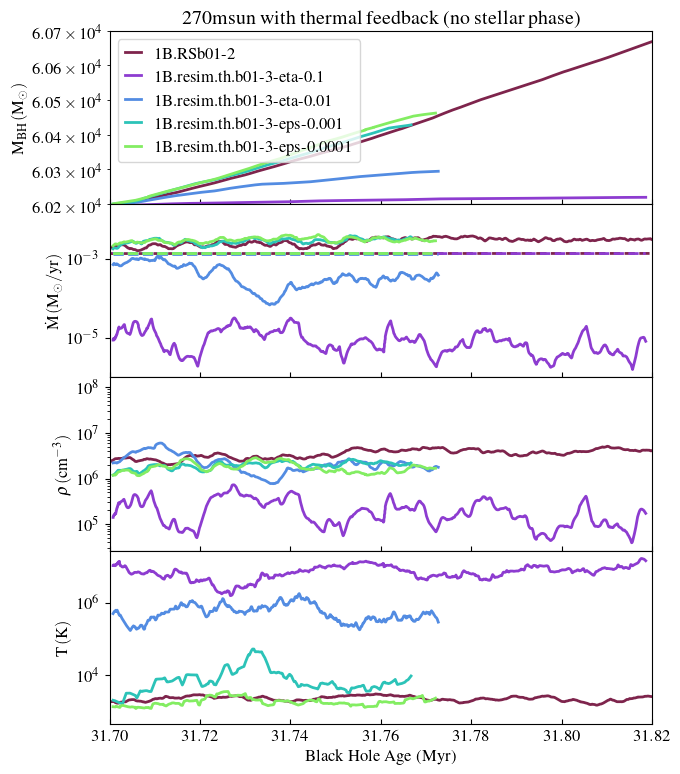

In [51]:

fig, axs = plt.subplots(num_subplots, 1)
window_size = 100
age_units = None # or "t_cs" or None
for j, data_file in enumerate(data_files):

    # Load the CSV file into a DataFrame
    df = pd.read_csv(data_file)

    # Extract the columns you're interested in
    #age = df['age'].values/1e6
    age = (df['age'].values/1e6)/t_cs.mean() if age_units == "t_cs" else (df['age'].values/1e6)/t_ff if age_units == "t_ff" else df['age'].values/1e6
    bh_mass = adaptive_moving_average(df['BH mass'].values, window_size)
    accrate = adaptive_moving_average(df['accrate'].values, window_size)
    density = adaptive_moving_average(df['average density'].values, window_size)
    temperature = adaptive_moving_average(df['temperature'].values, window_size)

    # 1) BH Mass
    axs[0].plot(age, bh_mass, color=c[j], linestyle='solid', label=labels[j], alpha=alpha)

    # 2) Accretion Rates
    axs[1].plot(age, accrate, color=c[j], linestyle='solid', label=labels[j], alpha=alpha)
    axs[1].plot(age, eddington_rate(bh_mass), color=c[j], linestyle='dashed', label=labels[j], alpha=alpha)

    # 3) Density
    axs[2].plot(age, density, color=c[j], linestyle='solid', label=labels[j], alpha=alpha)

    # 3) temperature
    axs[3].plot(age, temperature, color=c[j], linestyle='solid', label=labels[j], alpha=alpha) #if j != 0 else None


# Force x-axis ticks to appear on all subplots
for i, ax in enumerate(axs):
    ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, direction="in")
    ax.set_xlim([31.70, 31.82]) # set xlim
    ax.set_xticklabels([]) if i < 3 else None

# Set y-axis limits
axs[0].set_yscale('log')
axs[1].set_yscale('log')
axs[2].set_yscale('log')
axs[3].set_yscale('log')
axs[0].set_ylim([6.02e4, 6.07e4])
axs[2].set_ylim([5e5, 1e7])

# Set labels
axs[0].set_ylabel(r"$\rm M_{BH} \, (M_{\odot})$", fontdict=None)
axs[1].set_ylabel(r"$\rm \dot{M} \, (M_{\odot}/yr)$", fontdict=None)
axs[2].set_ylabel(r"$\rm \rho \, (cm^{-3})$", fontdict=None)
axs[3].set_ylabel(r"$\rm T \, (K)$", fontdict=None)
if age_units == "t_cs":
    axs[-1].set_xlabel(r'$t_{{c_s}} (t_{{c_s}} = {:.0e}$ Myr, line \ {})'.format(t_cs.mean(), rho_index+1), fontdict=None)
elif age_units == "t_ff":
    axs[-1].set_xlabel(r'$t_{{ff}} (\rho = {:.0e}, line \ {})$'.format(rho, rho_index+1), fontdict=None)
else:
    axs[-1].set_xlabel('Black Hole Age (Myr)', fontdict=None)

# legend and title
axs[0].legend(fontsize=fontsize, ncol=1, loc="upper left", handlelength=1) # "lower right" for no-sn
axs[0].set_title(title)
fig.subplots_adjust(wspace=0, hspace=0)
fig.set_size_inches(7, 9)

(1209,) (1209,)
(1209,) (1209,)
(742,) (742,)
(742,) (742,)
(667,) (667,)
(667,) (667,)
(725,) (725,)
(725,) (725,)


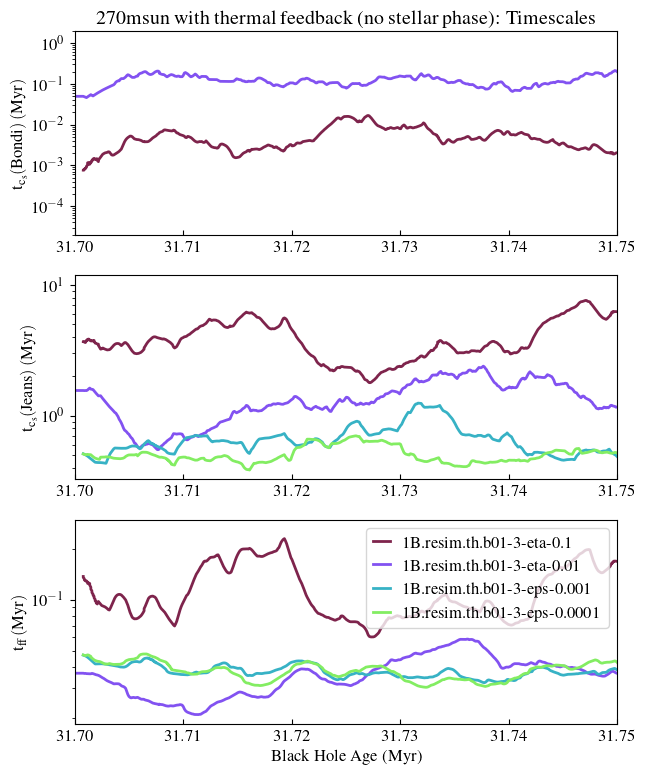

In [29]:
from scipy.interpolate import interp1d

# timescales plot
fig, axs = plt.subplots(3, 1, sharex=True)
window_size = 100
age_units = None # or "t_cs" or None
for j, data_file in enumerate(data_files):

    # Load the CSV file into a DataFrame
    df = pd.read_csv(data_file)

    # sound crossing timescale Bondi
    t_cs = adaptive_moving_average(sound_crossing_timescale(df, window_size, type='bondi'), window_size)

    # # sound crossing timescale Jeans
    t_jeans = adaptive_moving_average(sound_crossing_timescale(df, window_size, type='jeans'), window_size)

    # # find the dynamical timescale 
    mh = 1.6735e-24 # hydrogen mass in g
    density = adaptive_moving_average(df['average density'].values, window_size)
    t_ff = dynamical_timescale_ff(density*mh)/3.15576e13

    # Assuming df['age'].values and t_cs are available and sorted
    x_original = np.linspace(0, 1, len(df['age'].values))  # Normalize original x-axis
    x_new = np.linspace(0, 1, len(t_cs))  # New x-axis for interpolation

    # Create interpolation function
    interp_func = interp1d(x_original, df['age'].values/1e6)

    # Interpolate 'age' to match 't_cs' length
    age_interpolated = interp_func(x_new)

    # plot the timescales
    axs[0].plot(adaptive_moving_average(age_interpolated, int(len(df['age'].values)/len(t_cs))), t_cs, color=c[j], linestyle='solid', label=labels[j], alpha=alpha)
    axs[1].plot(adaptive_moving_average(age_interpolated, int(len(df['age'].values)/len(t_jeans))), t_jeans, color=c[j], linestyle='solid', label=labels[j], alpha=alpha)
    axs[2].plot(df['age'].values/1e6, t_ff, color=c[j], linestyle='solid', label=labels[j], alpha=alpha)

# Force x-axis ticks to appear on all subplots
for i, ax in enumerate(axs):
    ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, direction="in")
    if i != (num_subplots - 1): ax.set_label('')

# Set labels
for i in range(3):
    axs[i].set_yscale('log')

# set axes labels
axs[0].set_ylabel(r"$\rm t_{c_s} (Bondi) \, (Myr)$", fontdict=None)
axs[1].set_ylabel(r"$\rm t_{c_s} (Jeans) \, (Myr)$", fontdict=None)
axs[2].set_ylabel(r"$\rm t_{ff} \, (Myr)$", fontdict=None)
axs[-1].legend(fontsize=fontsize, ncol=1, loc="upper right", handlelength=1) 
axs[-1].set_xlabel('Black Hole Age (Myr)', fontdict=None)


# Set axes limits
axs[0].set_ylim([2e-5, 2])
axs[-1].set_xlim([31.70, 31.75]) # for truncated view
#axs[-1].set_xlim([0, 1.4])
#axs[1].set_ylim([2e-6, 2e-1]) # 
axs[0].set_title('270msun with thermal feedback (no stellar phase): Timescales')
fig.set_size_inches(7, 9)
